 
Федеральное государственное автономное образовательное
 учреждение высшего образования 
«Национальный исследовательский университет ИТМО»


Факультет технологий искусственного интеллекта


Статистика и анализ данных
`Лабораторная работа №3`


Студент: `Вдовин Герман Евгеньевич `

Группа: `J3113`

Учебная группа: `2.1`

ISU: `408366`

Преподаватель: `Свинцов Михаил Викторович`


### Ход работы

1. Генерация данных с расчетом оценок

2. Бутстрапирование и доверительные интервалы

3. Исследование влияния объема выборки и числа итераций

4. Проверка покрытия интервалов

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [7]:
N = 500
SCALE = 10

sample = np.random.exponential(scale=SCALE, size=N)

### Базовые оценки

In [ ]:
sample_mean = np.mean(sample)
sample_median = np.median(sample)
sample_var = np.var(sample, ddof=1)
sample_iqr = stats.iqr(sample)

    
lmbd = 1 / SCALE
theoretical = {
    "mean": 1 / lmbd,
    "median": np.log(2) / lmbd,
    "var": 1 / (lmbd**2),
    "iqr": stats.expon.ppf(0.75, scale=SCALE) - stats.expon.ppf(0.25, scale=SCALE)
}


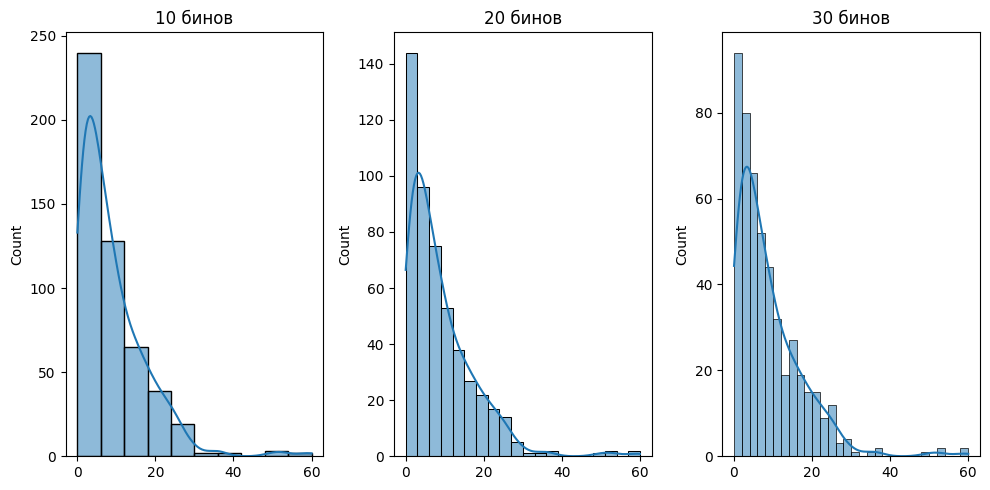

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

for ax, bins in zip(axs, [10, 20, 30]):
    sns.histplot(sample, bins=bins, kde=True, label=f"{bins} бинов", ax=ax)
    ax.set_title(f"{bins} бинов")

plt.tight_layout()
plt.show()

### Бутстрап для точных оценок

In [28]:
B = 1000
bootstrap_stat = lambda func: [func(np.random.choice(sample, size=N, replace=True)) for _ in range(B)]

In [38]:
boot_data = {
    "mean": (bootstrap_stat(np.mean), np.mean(sample)),
    "median": (bootstrap_stat(np.median), np.median(sample)),
    "std": (bootstrap_stat(lambda x: np.var(x, ddof=1)), np.var(sample, ddof=1)),
    "iqr": (bootstrap_stat(stats.iqr), stats.iqr(sample))
}

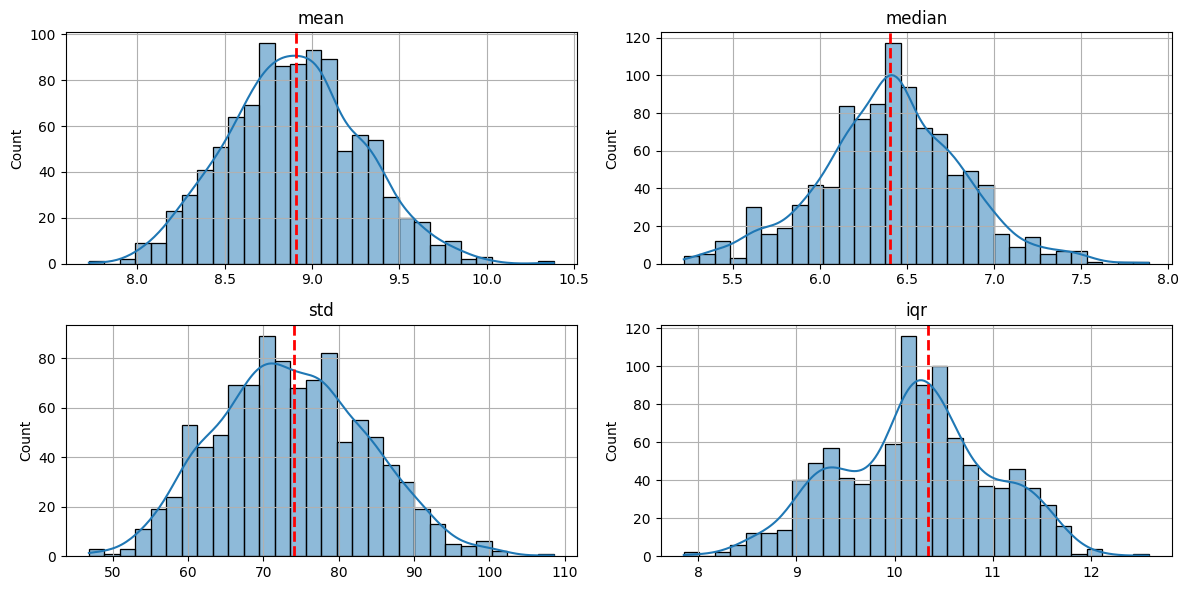

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for ax, (label, (boot_vals, original)) in zip(axes.flat, boot_data.items()):
    sns.histplot(boot_vals, bins=30, kde=True, ax=ax)
    ax.grid()
    ax.axvline(original, color='red', linestyle='--', linewidth=2)
    ax.set_title(label)

plt.tight_layout(); plt.show()

### Построение доверительных интегралов

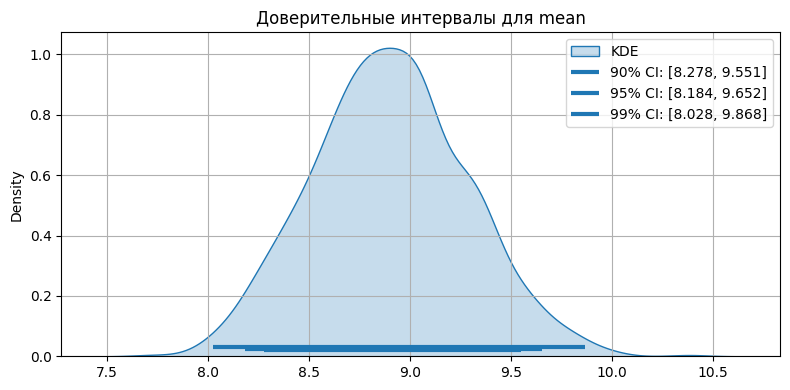

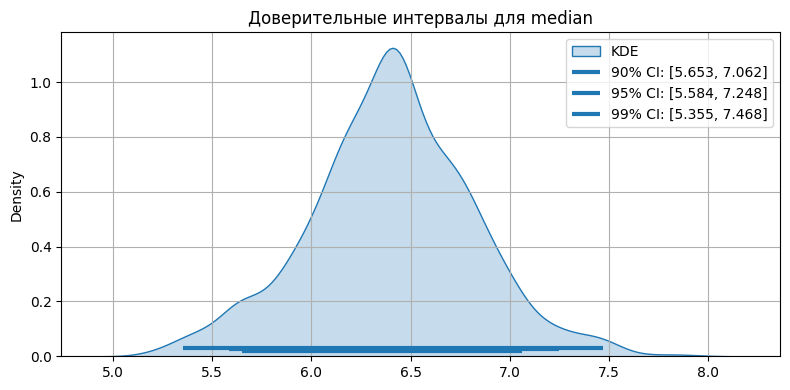

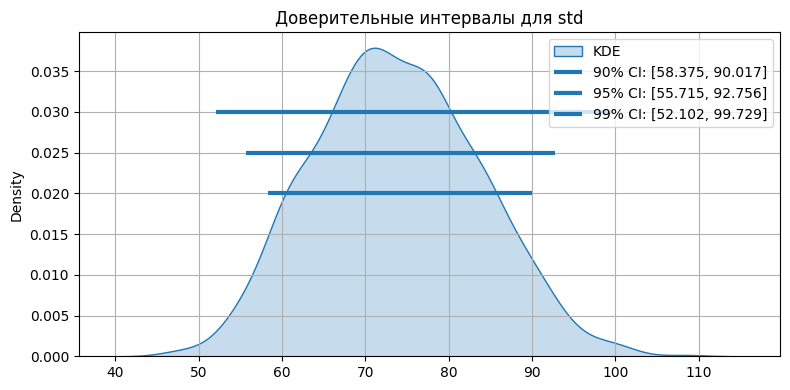

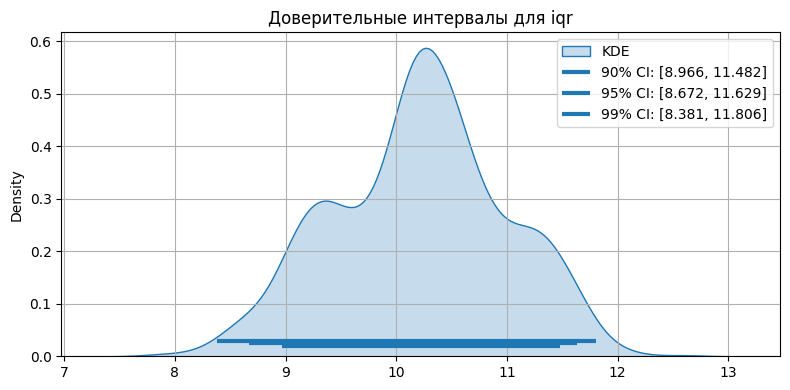

In [49]:
for name, (boot_vals, _) in boot_data.items():
    plt.figure(figsize=(8, 4))
    sns.kdeplot(boot_vals, label="KDE", fill=True)
    
    for i, cl in enumerate([0.90, 0.95, 0.99]):
        alpha = 1 - cl
        low, high = np.percentile(boot_vals, [100 * alpha / 2, 100 * (1 - alpha / 2)])
        plt.hlines(y=0.02 + i*0.005, xmin=low, xmax=high, linewidth=3,
                   label=f"{int(cl*100)}% CI: [{low:.3f}, {high:.3f}]")
    
    plt.title(f"Доверительные интервалы для {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Влияние объема выборки и числа итераций

In [ ]:
widths_N = []
for N in [50, 100, 200, 500, 1000]:
    cl = .95
    b = 1000
    ci = np.percentile(
        [
            np.mean(
                np.random.choice(
                    np.random.exponential(scale=SCALE, size=N), size=N, replace=True
                )
            )
            for _ in range(b)
        ],
        [2.5, 1 - cl],
    )
    widths_N.append(ci[1] - ci[0])

In [ ]:
widths_B = []
for B in [100, 200, 400, 1600, 3200]:
    n = 500
    cl = 0.95
    ci = np.percentile(
        [
            np.mean(
                np.random.choice(
                    np.random.exponential(scale=SCALE, size=n), size=n, replace=True
                )
            )
            for _ in range(B)
        ],
        [2.5, 1 - cl],
    )
    widths_B.append(ci[1] - ci[0])

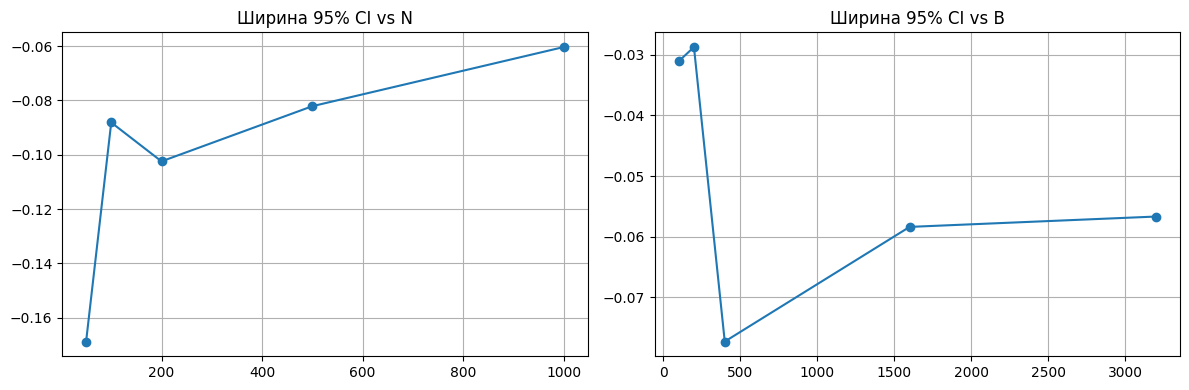

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot([50, 100, 200, 500, 1000], widths_N, marker='o')
axes[0].set_title("Ширина 95% CI vs N")
axes[0].grid(True)

axes[1].plot([100, 200, 400, 1600, 3200], widths_B, marker='o')
axes[1].set_title("Ширина 95% CI vs B")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Проверка покрытия интервалов

In [90]:
alpha = 0.05
u = 0

results = []
for N in [50, 100, 200, 500, 1000]:
    for B in [100, 200, 400, 1600, 3200]:
        count_contains_true = 0

        for _ in range(100):
            sample = np.random.normal(loc=u, scale=1, size=N)
            boot_means = [np.mean(np.random.choice(sample, size=N, replace=True)) for _ in range(B)]
            ci = np.percentile(boot_means, [100 * alpha / 2, 100 * (1 - alpha / 2)])
            if ci[0] <= u <= ci[1]:
                count_contains_true += 1

        results.append([N, B, count_contains_true / 100])

In [ ]:
# табличка
df = pd.DataFrame(results, columns=["Объем выборки N", "Число итераций B", "Доля покрытия"])
df

,Объем выборки N,Число итераций B,Доля покрытия
0,50,100,0.89
1,50,200,0.97
2,50,400,0.95
3,50,1600,0.96
4,50,3200,0.95
5,100,100,0.93
6,100,200,0.95
7,100,400,0.93
8,100,1600,0.97
9,100,3200,0.95


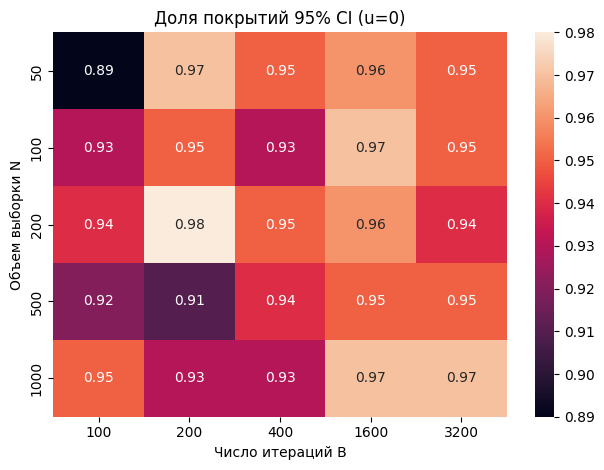

In [101]:
sns.heatmap(df.pivot(
    index="Объем выборки N",
    columns="Число итераций B",
    values="Доля покрытия"), annot=True, fmt=".2f")

plt.title("Доля покрытий 95% CI (u=0)")
plt.tight_layout()
plt.show()